In [ ]:
# Install dependencies
!pip install torch torchvision mediapipe

# Imports
import cv2
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import mediapipe as mp

In [ ]:
# Upload image
def upload_photo():
    uploaded = files.upload()  # opens file picker
    if uploaded:
        filename = list(uploaded.keys())[0]
        # Read uploaded file into OpenCV
        file_bytes = np.frombuffer(uploaded[filename], np.uint8)
        img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
        if img is None:
            print("❌ Failed to load image")
        else:
            print(f"✅ Uploaded: {filename}")
        return img
    return None

# Capture from webcam
def capture_photo():
    js = """
    async function capture() {
        const div = document.createElement('div');
        const video = document.createElement('video');
        const btn = document.createElement('button');
        btn.textContent = 'Capture Photo';
        btn.style.padding='12px 24px'; btn.style.fontSize='16px';
        btn.style.backgroundColor='#4285f4'; btn.style.color='white';
        btn.style.border='none'; btn.style.borderRadius='4px'; btn.style.cursor='pointer';
        div.appendChild(btn); div.appendChild(video); document.body.appendChild(div);
        const stream = await navigator.mediaDevices.getUserMedia({video:true});
        video.srcObject = stream; video.play();
        return new Promise((resolve) => {
            btn.onclick = () => {
                const canvas=document.createElement('canvas');
                canvas.width=video.videoWidth; canvas.height=video.videoHeight;
                canvas.getContext('2d').drawImage(video,0,0);
                stream.getTracks().forEach(track=>track.stop());
                div.remove();
                resolve(canvas.toDataURL('image/jpeg',0.9));
            };
        });
    }
    """
    try:
        data = eval_js(js + "capture()")
        binary = b64decode(data.split(',')[1])
        img_array = np.frombuffer(binary, dtype=np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        print("✅ Captured photo from webcam")
        return img
    except Exception as e:
        print(f"❌ Webcam error: {e}")
        return None

In [ ]:
from torchvision import models, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# DenseNet / Transformer Feature Extractor
# -----------------------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Pretrained vision transformer (or DenseNet)
vit_model = models.vit_b_16(pretrained=True).to(device)
vit_model.eval()

# -----------------------------
# Mediapipe for detection and landmarks
# -----------------------------
mp_face = mp.solutions.face_detection
mp_mesh = mp.solutions.face_mesh

class TransformerFaceRecognizer:
    def __init__(self, threshold=0.75):
        self.threshold = threshold
        self.face_database = {}  # name -> list of embeddings
        self.face_detection = mp_face.FaceDetection(model_selection=1, min_detection_confidence=0.7)
        self.face_mesh = mp_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

    # -----------------------------
    # Face detection
    # -----------------------------
    def detect_faces(self, image):
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.face_detection.process(rgb)
        faces = []
        if results.detections:
            h, w = image.shape[:2]
            for det in results.detections:
                bbox = det.location_data.relative_bounding_box
                conf = det.score[0]
                if conf > 0.7:
                    x = max(0,int(bbox.xmin*w))
                    y = max(0,int(bbox.ymin*h))
                    w_box = min(int(bbox.width*w), w-x)
                    h_box = min(int(bbox.height*h), h-y)
                    faces.append((x,y,w_box,h_box))
        return faces

    # -----------------------------
    # Extract transformer embeddings
    # -----------------------------
    def extract_face_features(self, face_image):
        try:
            face_tensor = transform(face_image).unsqueeze(0).to(device)
            with torch.no_grad():
                emb = vit_model(face_tensor).detach().cpu().numpy()[0]
            emb = emb / np.linalg.norm(emb)
            return emb
        except:
            return None

    # -----------------------------
    # Extract geometric ratios
    # -----------------------------
    def extract_landmark_ratios(self, image):
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = self.face_mesh.process(rgb)
        if not result.multi_face_landmarks:
            return None
        h,w = image.shape[:2]
        lm = result.multi_face_landmarks[0].landmark
        coords = np.array([[p.x*w,p.y*h] for p in lm])
        left_eye = np.mean(coords[33:133], axis=0)
        right_eye = np.mean(coords[362:389], axis=0)
        nose_tip = coords[1]
        mouth_top = coords[13]
        mouth_bottom = coords[14]
        chin = coords[152]
        eye_distance = np.linalg.norm(left_eye-right_eye)
        nose_to_mouth = np.linalg.norm(nose_tip-mouth_top)
        mouth_height = np.linalg.norm(mouth_top-mouth_bottom)
        face_height = np.linalg.norm(chin-nose_tip)
        symmetry = np.abs(left_eye[1]-right_eye[1])
        ratios = np.array([
            eye_distance/face_height,
            nose_to_mouth/face_height,
            mouth_height/face_height,
            symmetry/face_height
        ])
        return ratios/np.linalg.norm(ratios)

    # -----------------------------
    # Register faces
    # -----------------------------
    def register_faces(self, image, names):
        faces = self.detect_faces(image)
        if len(faces) != len(names):
            print(f"❌ Detected {len(faces)} faces but got {len(names)} names.")
            return False
        for (x,y,w,h), name in zip(faces,names):
            face = image[y:y+h,x:x+w]
            emb = self.extract_face_features(face)
            geom = self.extract_landmark_ratios(face)
            if emb is not None and geom is not None:
                combined = np.concatenate([emb,geom])
                if name not in self.face_database:
                    self.face_database[name] = []
                self.face_database[name].append(combined)
                print(f"✅ Registered '{name}'")
        return True

    # -----------------------------
    # Recognize faces
    # -----------------------------
    def recognize_faces(self, image):
        faces = self.detect_faces(image)
        results = []
        if not faces:
            return results
        for (x,y,w,h) in faces:
            face = image[y:y+h, x:x+w]
            emb = self.extract_face_features(face)
            geom = self.extract_landmark_ratios(face)
            if emb is None or geom is None:
                results.append({'bbox':(x,y,w,h),'name':'No Face','total_score':0.0})
                continue
            combined = np.concatenate([emb,geom])
            # Compare with database
            best_name, best_score = "Unknown", 0.0
            for name, db_embs in self.face_database.items():
                sims = [cosine_similarity([combined],[db])[0][0] for db in db_embs]
                score = np.mean(sims)
                # Optional: apply sigmoid for smooth confidence
                score = 1/(1+np.exp(-10*(score-0.5)))
                if score>best_score:
                    best_score = score
                    best_name = name
            results.append({
                'bbox':(x,y,w,h),
                'name':best_name,
                'total_score':float(best_score)
            })
        return results

    # -----------------------------
    # Clear DB
    # -----------------------------
    def clear_database(self):
        self.face_database.clear()
        print("🧹 Cleared all registered faces.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



===== FACE RECOGNITION MENU =====
1️⃣ Register Faces
2️⃣ Recognize Faces
3️⃣ Clear All Registered Data
4️⃣ Exit
Enter choice (1-4): 1
Choose input method: 1 = Upload, 2 = Webcam: 2
❌ Webcam error: NotAllowedError: Permission denied

===== FACE RECOGNITION MENU =====
1️⃣ Register Faces
2️⃣ Recognize Faces
3️⃣ Clear All Registered Data
4️⃣ Exit
Enter choice (1-4): 1
Choose input method: 1 = Upload, 2 = Webcam: 1


Saving WhatsApp Image 2025-10-18 at 00.22.20_35366b76.jpg to WhatsApp Image 2025-10-18 at 00.22.20_35366b76.jpg
✅ Uploaded: WhatsApp Image 2025-10-18 at 00.22.20_35366b76.jpg


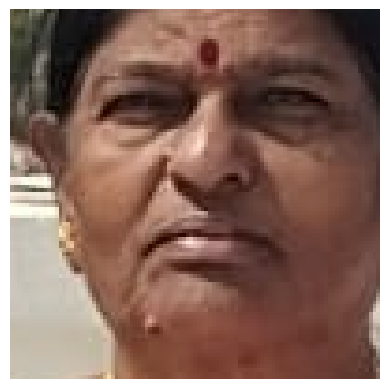

Enter name for Face 1: jayamma


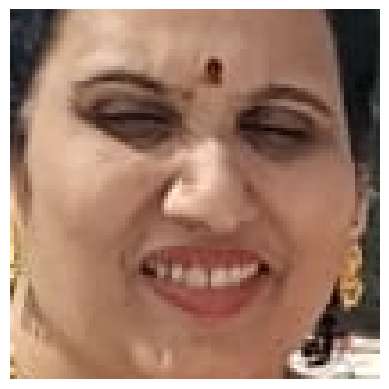

Enter name for Face 2: kamala


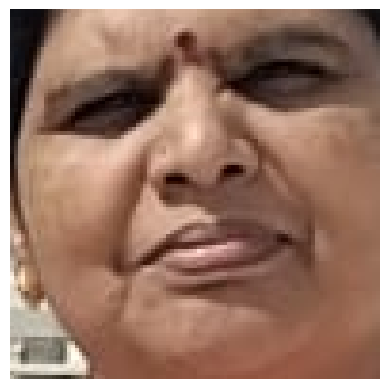

Enter name for Face 3: vijaya


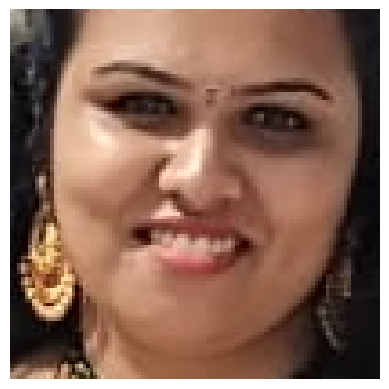

Enter name for Face 4: sreeja


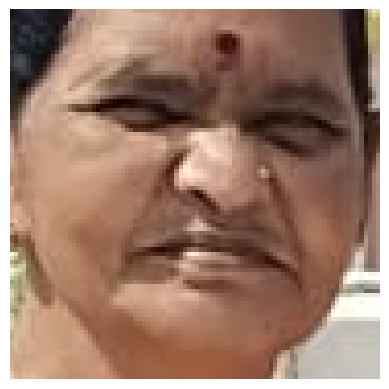

Enter name for Face 5: subbalakshmi
✅ Registered 'jayamma'
✅ Registered 'kamala'
✅ Registered 'vijaya'
✅ Registered 'sreeja'
✅ Registered 'subbalakshmi'

===== FACE RECOGNITION MENU =====
1️⃣ Register Faces
2️⃣ Recognize Faces
3️⃣ Clear All Registered Data
4️⃣ Exit
Enter choice (1-4): 2
Choose input method: 1 = Upload, 2 = Webcam: 1


Saving WhatsApp Image 2025-10-18 at 00.29.19_4f0a895d.jpg to WhatsApp Image 2025-10-18 at 00.29.19_4f0a895d.jpg
✅ Uploaded: WhatsApp Image 2025-10-18 at 00.29.19_4f0a895d.jpg


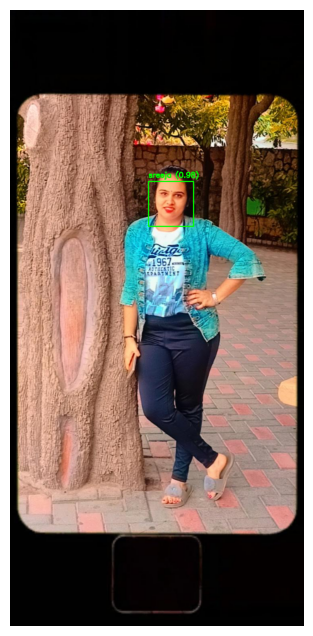


===== FACE RECOGNITION MENU =====
1️⃣ Register Faces
2️⃣ Recognize Faces
3️⃣ Clear All Registered Data
4️⃣ Exit
Enter choice (1-4): 2
Choose input method: 1 = Upload, 2 = Webcam: 1


Saving WhatsApp Image 2025-10-18 at 00.22.20_79a02147.jpg to WhatsApp Image 2025-10-18 at 00.22.20_79a02147.jpg
✅ Uploaded: WhatsApp Image 2025-10-18 at 00.22.20_79a02147.jpg


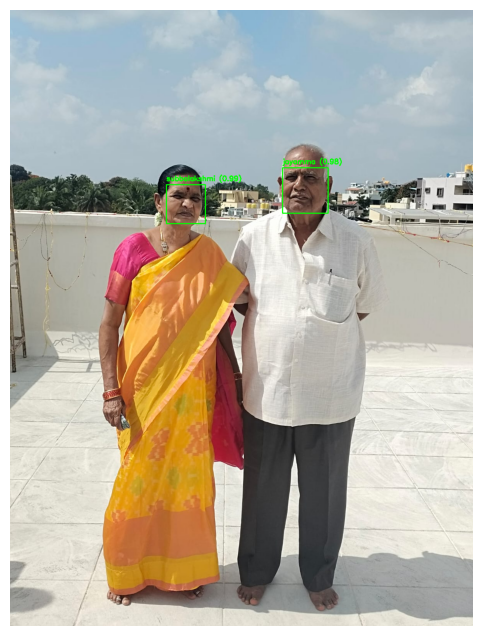


===== FACE RECOGNITION MENU =====
1️⃣ Register Faces
2️⃣ Recognize Faces
3️⃣ Clear All Registered Data
4️⃣ Exit
Enter choice (1-4): 2
Choose input method: 1 = Upload, 2 = Webcam: 2
❌ Webcam error: NotAllowedError: Permission denied

===== FACE RECOGNITION MENU =====
1️⃣ Register Faces
2️⃣ Recognize Faces
3️⃣ Clear All Registered Data
4️⃣ Exit
Enter choice (1-4): 2
Choose input method: 1 = Upload, 2 = Webcam: 1


Saving Screenshot 2025-10-18 002510.png to Screenshot 2025-10-18 002510.png
✅ Uploaded: Screenshot 2025-10-18 002510.png


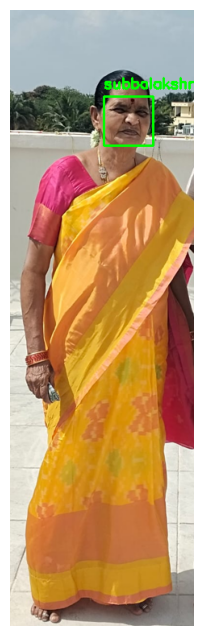


===== FACE RECOGNITION MENU =====
1️⃣ Register Faces
2️⃣ Recognize Faces
3️⃣ Clear All Registered Data
4️⃣ Exit
Enter choice (1-4): 1
Choose input method: 1 = Upload, 2 = Webcam: 1


Saving WhatsApp Image 2025-10-18 at 21.55.46_0d2b52ef.jpg to WhatsApp Image 2025-10-18 at 21.55.46_0d2b52ef.jpg
✅ Uploaded: WhatsApp Image 2025-10-18 at 21.55.46_0d2b52ef.jpg


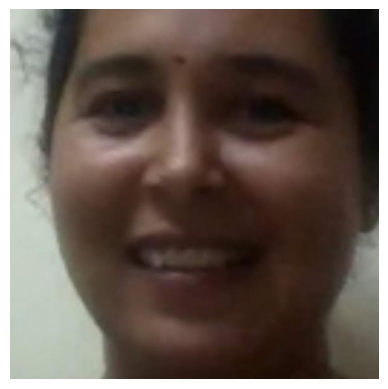

Enter name for Face 1: gayathri
✅ Registered 'gayathri'

===== FACE RECOGNITION MENU =====
1️⃣ Register Faces
2️⃣ Recognize Faces
3️⃣ Clear All Registered Data
4️⃣ Exit
Enter choice (1-4): 2
Choose input method: 1 = Upload, 2 = Webcam: 1


Saving WhatsApp Image 2025-10-18 at 21.39.30_f59a9fdb.jpg to WhatsApp Image 2025-10-18 at 21.39.30_f59a9fdb.jpg
✅ Uploaded: WhatsApp Image 2025-10-18 at 21.39.30_f59a9fdb.jpg


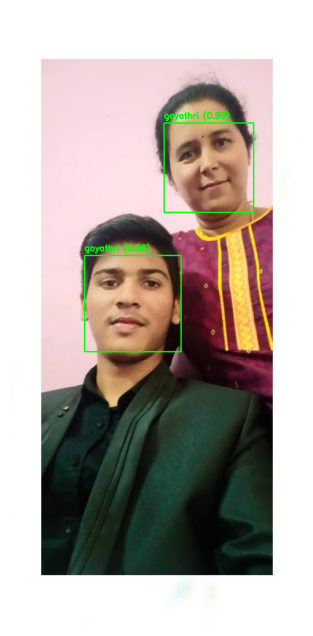


===== FACE RECOGNITION MENU =====
1️⃣ Register Faces
2️⃣ Recognize Faces
3️⃣ Clear All Registered Data
4️⃣ Exit
Enter choice (1-4): 1


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

recognizer = TransformerFaceRecognizer()

# -----------------------------
# Draw landmarks
# -----------------------------
def draw_landmarks(image, face_mesh):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = face_mesh.process(rgb)
    if not result.multi_face_landmarks:
        return image
    h,w = image.shape[:2]
    for lm in result.multi_face_landmarks[0].landmark:
        cx,cy = int(lm.x*w), int(lm.y*h)
        cv2.circle(image,(cx,cy),1,(0,255,0),-1)
    return image

# -----------------------------
# Main Menu
# -----------------------------
while True:
    print("\n===== FACE RECOGNITION MENU =====")
    print("1️⃣ Register Faces")
    print("2️⃣ Recognize Faces")
    print("3️⃣ Clear All Registered Data")
    print("4️⃣ Exit")
    choice = input("Enter choice (1-4): ").strip()

    if choice=='1':
        method = input("Choose input method: 1 = Upload, 2 = Webcam: ").strip()
        img = upload_photo() if method=='1' else capture_photo()
        if img is None: continue
        faces = recognizer.detect_faces(img)
        if not faces:
            print("❌ No faces detected")
            continue
        names = []
        for i,(x,y,w,h) in enumerate(faces):
            face_crop = img[y:y+h,x:x+w]
            plt.imshow(cv2.cvtColor(face_crop,cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()
            name = input(f"Enter name for Face {i+1}: ").strip() or f"Person_{i+1}"
            names.append(name)
        recognizer.register_faces(img,names)

    elif choice=='2':
        method = input("Choose input method: 1 = Upload, 2 = Webcam: ").strip()
        img = upload_photo() if method=='1' else capture_photo()
        if img is None: continue
        results = recognizer.recognize_faces(img)
        img_display = img.copy()
        for res in results:
            x,y,w,h = res['bbox']
            name = res['name']
            score = res.get('total_score',0.0)
            color = (0,255,0) if name!="Unknown" else (0,0,255)
            cv2.rectangle(img_display,(x,y),(x+w,y+h),color,2)
            cv2.putText(img_display,f"{name} ({score:.2f})",(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,color,2)
        plt.figure(figsize=(10,8))
        plt.imshow(cv2.cvtColor(img_display,cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()

    elif choice=='3':
        confirm = input("Clear all data? (y/n): ").strip().lower()
        if confirm=='y': recognizer.clear_database()

    elif choice=='4':
        print("👋 Exiting"); break
    else:
        print("❌ Invalid choice")